In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
def get_unique_elements(data):
    '''Function to get a list of all the unique elements in a pandas dataframe'''
    
    unique_elements = []

    for col in data:
    
        unique = np.unique(data[col]) # List of unique elements in a column of the dataframe
        
        unique_elements.append(unique)
        
    return unique_elements

def get_best_samples(data, desired_value, n, method):
    '''Funcion to get the n best samples i.e. alloys with the closest values of the
    desired property (thermal conductivity or tensile strength)'''
    
    # method = 1 ---> 'Tensile Strength'
    # method = 2 ---> 'Thermal Conductivity'
    target = 'tensile_strength' if method == 1 else 'thermal_conductivity'
    
    # Calculate absolute difference between actual and desired values
    abs_diff = abs(data[target] - desired_value)
    
    # Store index values of 'n' samples with values closest to the desired value
    best_sample_ids = np.argsort(abs_diff)[:n]
    
    # Return the best samples from the data using the index values
    best_samples = data.iloc[best_sample_ids]
    
    # Return only necessary columns according to the method
    if method == 1:
        best_samples = best_samples.iloc[:, :-2]
    elif method == 2:
        best_samples = best_samples.iloc[:,-30:-2]
    
    return best_samples

def all_possible_combinations(unique_elements):
    '''Generates a list of all the unqiue combinations from a list of unique elements'''
    
    import itertools
    
    # Create a list of all unique value lists in unique_elements
    a = [ele for ele in unique_elements]
    
    # Generate a list of all possible permutations of the list elements in a
    permutations_list = list(itertools.product(*a))
    
    return permutations_list

def confidence_percentage(desired_compositions, desired_value, model_accuracy):
    '''Returns the level of confidence for each result as a percentage'''
    
    predictions = model.predict(desired_compositions)
    
    error_perc = abs(predictions - desired_value) / desired_value * 100
    
    conf_perc = 100 - error_perc
    
    tot_conf_perc = conf_perc * model_accuracy
    
    return tot_conf_perc

def generate_synthetic_datapoints(desired_value, data, method, n=10):
    '''Returns a pandas dataframe consisting of synthesised datapoints generated from randomising existing data'''   
    
    import pandas as pd
    
    # method = 1 ---> 'Tensile Strength'
    # method = 2 ---> 'Thermal Conductivity'
    best_samples = get_best_samples(data = data, desired_value = desired_value, n = n, method = method)
    
    unique_elements = get_unique_elements(data = best_samples)
    
    permutations_list = all_possible_combinations(unique_elements = unique_elements)
    
    synthetic_data_df = pd.DataFrame(permutations_list, columns = best_samples.columns)
    
    if method == 1:
        condition1 = synthetic_data_df.iloc[:,:17].sum(axis=1) == 1 # Ensures exactly one of the form columns is chosen
        condition2 = synthetic_data_df.loc[:,'H00' : 'WR02'].sum(axis=1) == 1 # Ensures exactly one of the temper columns is chosen

        synthetic_data_df = synthetic_data_df[condition1 & condition2]
        
    # Ensure that the total sum of composition percentages is 100%
    start_idx = np.argwhere(synthetic_data_df.columns == 'cu')[0,0]  # Get the index value of copper column 

    composition_columns = synthetic_data_df.iloc[:, start_idx :]  # Select composition columns (columns after 'cu')

    synthetic_data_df.iloc[:, start_idx :] = rectify_composition(composition_columns) # Normalize data    
    
    return synthetic_data_df

def select_appropriate_model(method):
    '''Loads the appropriate ML model corresponding to 1. Tensile Strength and 2. Thermal Conductivity'''
    
    import pickle
    
    # Select appropriate model for the problem
    if method == 1:   
        model_filepath = 'rf_tensile_strength.pickle'  # Model to predict Tensile Strength

    elif method == 2:   
        model_filepath = 'rf_thermal_conductivity.pickle'  # Model to predict Thermal Conductivity

    # Load model corresponding to the METHOD
    with open(model_filepath, 'rb') as f:
        model = pickle.load(f)
        
    return model

def rectify_composition(data):
    
    # Normalize composition to 100% 
    rectified_data = data.apply(lambda x : 100 * x / data.sum(axis=1))
    
    return rectified_data

def scan_dataset_for_value(desired_value, data, method):
    
    # method = 1 : Tensile Strength, method = 2 : Thermal Conductivity
    target = "tensile_strength" if method == 1 else "thermal_conductivity"
    
    # Obtain the compositions of alloys with desired value
    alloys_actual = data[data[target] == desired_value]
    
    # Obtain the relevant subset of data according to "method"
    if method == 1:
        alloys_actual = alloys_actual.iloc[:, :-2]
    elif method == 2:
        alloys_actual = alloys_actual.iloc[:,-30:-2]
    
    # Remove any duplicate results
    alloys_actual = alloys_actual[~alloys_actual.duplicated(keep='first')]
    
    # Since we're suggesting a REAL alloy, 100% confidence 
    alloys_actual.insert(0, "Confidence %", np.array([100] * len(alloys_actual)))  
    
    # Output the actual alloy data
    if len(alloys_actual) > 0:           
        return alloys_actual

def composition_from_value(desired_value, synth_data, model, method, n=10):
    
    # Pre-determined accuracy of models using mean accuracy from 10-Fold Cross Validation
    # Tensile Strength Model ---> 89.65%
    # Thermal Conductivity Model ---> 99.80%
    model_accuracy = 0.896573 if method == 1 else 0.787239

    # Use model to make predictions for synthetic data : "synth_data"
    predictions = model.predict(synth_data.iloc[:300000,:]) # Predictions on max 300,000 points to save time

    # Calculate absolute difference between the desireable Thermal Conducticity 
    # and the predictions on synthetic data
    difference = abs(predictions - desired_value)

    # Sort the indices of the absolute difference in ascending order, 
    # and store the indices of the first n predictions   
    indices = np.argsort(difference)[:n]

    # The composition of the materials with thermal conductivity closest to the desired value
    desired_compositions = synth_data.iloc[indices, :]
#     desired_compositions, perc_error = rectify_composition(desired_compositions) # Normalises to 100 and stores normalizing error (Note - max observed error = 2%)

    # Calculate the confidence of our results
    confidence_percentages = confidence_percentage(desired_compositions, 
                                                   model_accuracy=model_accuracy,
                                                   desired_value=desired_value)
#     confidence_percentages = confidence_percentages - perc_error  # Add the error from normalising to the total error

    # Store results in with desired compositions
    desired_compositions.insert(0, "Confidence %", confidence_percentages.round(1), allow_duplicates=False)
    
    # Add actual alloys with 100% confidence from the dataset if they have the desired value
    actual_alloys = scan_dataset_for_value(desired_value=desired_value, data=DATA, method=method)
    desired_compositions = pd.concat((actual_alloys, desired_compositions))
    
    # Remove unnecessary dummy variables
    desired_compositions = desired_compositions.loc[:, (desired_compositions != 0).any(axis=0)]

    # Sort alloys by confidence % (highest first)
    desired_compositions = desired_compositions.sort_values(by='Confidence %', ascending=False, )
    
    return desired_compositions.reset_index(drop=True).head(n)

In [ ]:
# User Input
METHOD = 1  # method = 1 : Tensile Strength, method = 2 : Thermal Conductivity
VALUE = 70
N = 10

# Program functionality

# Global Variables 
DATA = pd.read_csv("../../Copper Dataset (version 3.0).csv")

# Load model corresponding to the METHOD
model = select_appropriate_model(method = METHOD)
    
# Generate Synthetic Data for given Tensile Strength
synth_data = generate_synthetic_datapoints(desired_value = VALUE, data = DATA, method = METHOD, n = 10)

# Obtain most suitable alloy compositions with confidence percentage
results = composition_from_value(desired_value = VALUE, 
                                 synth_data = synth_data,
                                 model = model, 
                                 method = METHOD,
                                 n = N).round(2)
results

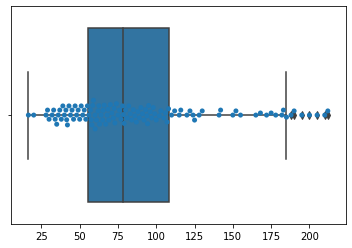

In [4]:
import seaborn as sns
sns.boxplot(DATA.tensile_strength.unique())
sns.swarmplot(DATA.tensile_strength.unique())

array([ 16.5 ,  36.05,  55.6 ,  75.15,  94.7 , 114.25, 133.8 , 153.35,
       172.9 , 192.45, 212.  ])

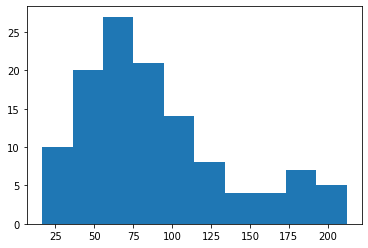

In [5]:
a, b, _= plt.hist(DATA.tensile_strength.unique(), bins=10)
b

In [ ]:
# User Input
METHOD = 1  # method = 1 : Tensile Strength, method = 2 : Thermal Conductivity
# Global Variables 
N = 10

# Load model corresponding to the METHOD
model = select_appropriate_model(method = METHOD)

for i in DATA.tensile_strength.unique():
    
    print("Tensile Strength =",i)
   
    VALUE = i
    
    # Program functionality  
    
    print("Generating data .....")
    
    # Generate Synthetic Data for given Tensile Strength
    synth_data = generate_synthetic_datapoints(desired_value = VALUE, data = DATA, method = METHOD, n = 10)
    
    print("Compiling compositions .....")
    
    # Obtain most suitable alloy compositions with confidence percentage
    results = composition_from_value(desired_value = VALUE, 
                                     synth_data = synth_data,
                                     model = model, 
                                     method = METHOD,
                                     n = N).round(2)
    print(i)
    print(results)
    
    print()